# Capstone - EYE FOR BLIND

## Problem statement

A significant portion of the global population, approximately 285 million people, faces visual impairment, with 39 million of them being completely blind. These individuals encounter substantial challenges in carrying out daily activities that rely on visual information, such as reading text (e.g., newspapers, messages) or understanding visual content like pictures and images. In today's digital and social media-driven world, where millions of images are shared daily, visually impaired and blind people face barriers in accessing and appreciating visual content, limiting their ability to engage with information, enjoy visual media, and fully participate in social and cultural activities.

This calls for the development of solutions that can help these individuals understand and interact with both text and image-based content more effectively.

## Solution

Make a model that is similar to the one developed by Facebook, specifically such that a blind person knows the contents of an image in front of them with the help of a CNN-RNN based model. The model will convert the contents of an image and will provide the output in the form of audio.

Image-to-caption generation which is based on the popular <a href="https://arxiv.org/pdf/1502.03044">Show, Attend and Tell paper.</a>

<h4>Encoder</h4>
The encoder parts involve the convolution of the input image with the help of various convolution, max pooling, and fully connected layers. Since we are not dealing with the classification of the image, we have removed them from the end. The final output of the encoder part will be the generation of the feature vector.

<h4>Attention model</h4>
Instead of passing the complete input image to the RNN at every timestamp, different relevant parts of the image is passed to it. With an attention model, we get a varying feature vector based on the previously generated word. This helps to look at different parts of the image for better captioning.

<h4>Decoder</h4>
The decoder predicts the word based on context vector generated by Attention model, along with hidden state from previous timestamp. The word is generated till it reaches the <b>end</b> tag.



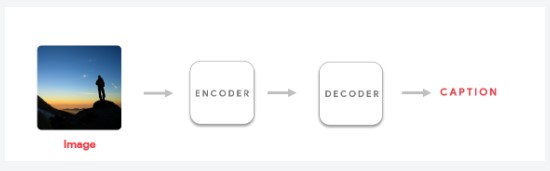

## Dataset

The dataset is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

Kaggle link - https://www.kaggle.com/adityajn105/flickr8k

## Below steps are followed to solve the problem

### 1. Data Understanding

Load the data and understand the representation.<br>

1.1. Data understanding<br>
1.2. Data processing<br>
1.3. Dataset creation<br>
1.4. Feature extraction<br>

### 2. Data Preprocessing

Process both images and captions to the desired format.<br>

2.1. Train test step<br>
2.2. Checkpoint creation<br>
2.3. Optimizer and loss setting<br>

### 3. Model Building
Create image captioning model by building Encoder, Attention and Decoder model.<br>

3.1. Build Encoder Model (INCEPTIONV3)<br>
3.2. Build Attention Model<br>
3.3. Build Decoder model<br>



### 4. Model Evaluation
Evaluate the models using greedy search and BLEU score.<br>

4.1. Greedy search<br>
4.2. Bean search<br>
4.3. Testing on Bleu score<br>


### 5. Conclusion

#### Import required libraries

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from nltk import FreqDist
import seaborn as sns
import numpy as np
from PIL import Image
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, ReLU, BatchNormalization, Dropout

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import time

## Install additional libraries for Audio

In [2]:
!pip install wordcloud
!pip install gtts
!pip install playsound

  Using cached wordcloud-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (520 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Using cached gTTS-2.5.3-py3-none-any.whl (29 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Using cached playsound-1.3.0-py3-none-any.whl
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## Import audio libraries

In [3]:
import glob
from gtts import gTTS
from playsound import playsound

import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [4]:
pd.set_option('display.max_colwidth', None)

# 1. Dataset Creation

## 1.1. Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



#### Import the dataset and read the image

In [5]:
images='datasets/flickr/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
all_imgs = [x.replace('\\', '/') for x in all_imgs]
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


#### Import the dataset and read the text file

In [6]:
def load_doc(filename):
    
    doc = pd.read_csv(filename, sep=',')
    
    return doc

text_file = 'datasets/flickr/captions.txt'
doc = load_doc(text_file)
display(doc.head(20))

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


#### Visualise both the images & text present in the dataset

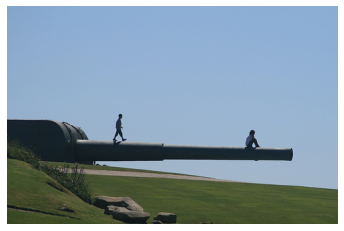

'--------------- CAPTIONS -----------------------------'

31865                Men , one walking , and one sitting balanced on a shaft .
31866    One boys sits on a giant mortar gun as another boy walks toward him .
31867      Two boys walk out on a military monument over grassy green fields .
31868                                      Two people are on top of a cannon .
31869                   Two people are walking along a long cannon on a tank .
Name: caption, dtype: object

In [7]:
image_path = all_imgs[0]

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

pd.set_option('display.max_colwidth', None)
display('--------------- CAPTIONS -----------------------------')
doc[doc['image']==image_path.split('/')[-1]]['caption']

#### Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
all_img_id= doc['image']
all_img_vector = images + '/' + doc['image']
annotations= doc['caption']

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
display(df.head(30))


,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,datasets/flickr/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,datasets/flickr/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,datasets/flickr/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457_577c3a7d70.jpg,datasets/flickr/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457_577c3a7d70.jpg,datasets/flickr/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [9]:
path = df[df['Captions'].str.lower().str.contains('bird')]['Path']


In [10]:
len(set(path))

91

In [11]:
#Create a list which contains all the captions
annotations=df['Captions']

#Create a list which contains all the path to the images
all_img_path=df['Path']

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [12]:
print('Dataframe shape: ',doc.shape)

Dataframe shape:  (40455, 2)


## 1.2. Data processing

#### Data cleaning

. Remove punctuation<br>
. Convert to lower<br>
. remove numeric values<br>

In [13]:
# remove extra space 
annotations = annotations.apply(lambda x: x.replace("\s+"," "))

rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotations)) :
    line = annotations[r]
    line = line.split()

    # converting to lowercase
    line = [word.lower() for word in line]

    # remove punctuation from each caption and hanging letters
    line = [word.translate(rem_punct) for word in line]
    
    # remove works with single word
    line = [word for word in line if len(word) > 1]
    
    # remove numeric values
    line = [word for word in line if word.isalpha()]

    annotations[r] = ' '.join(line)

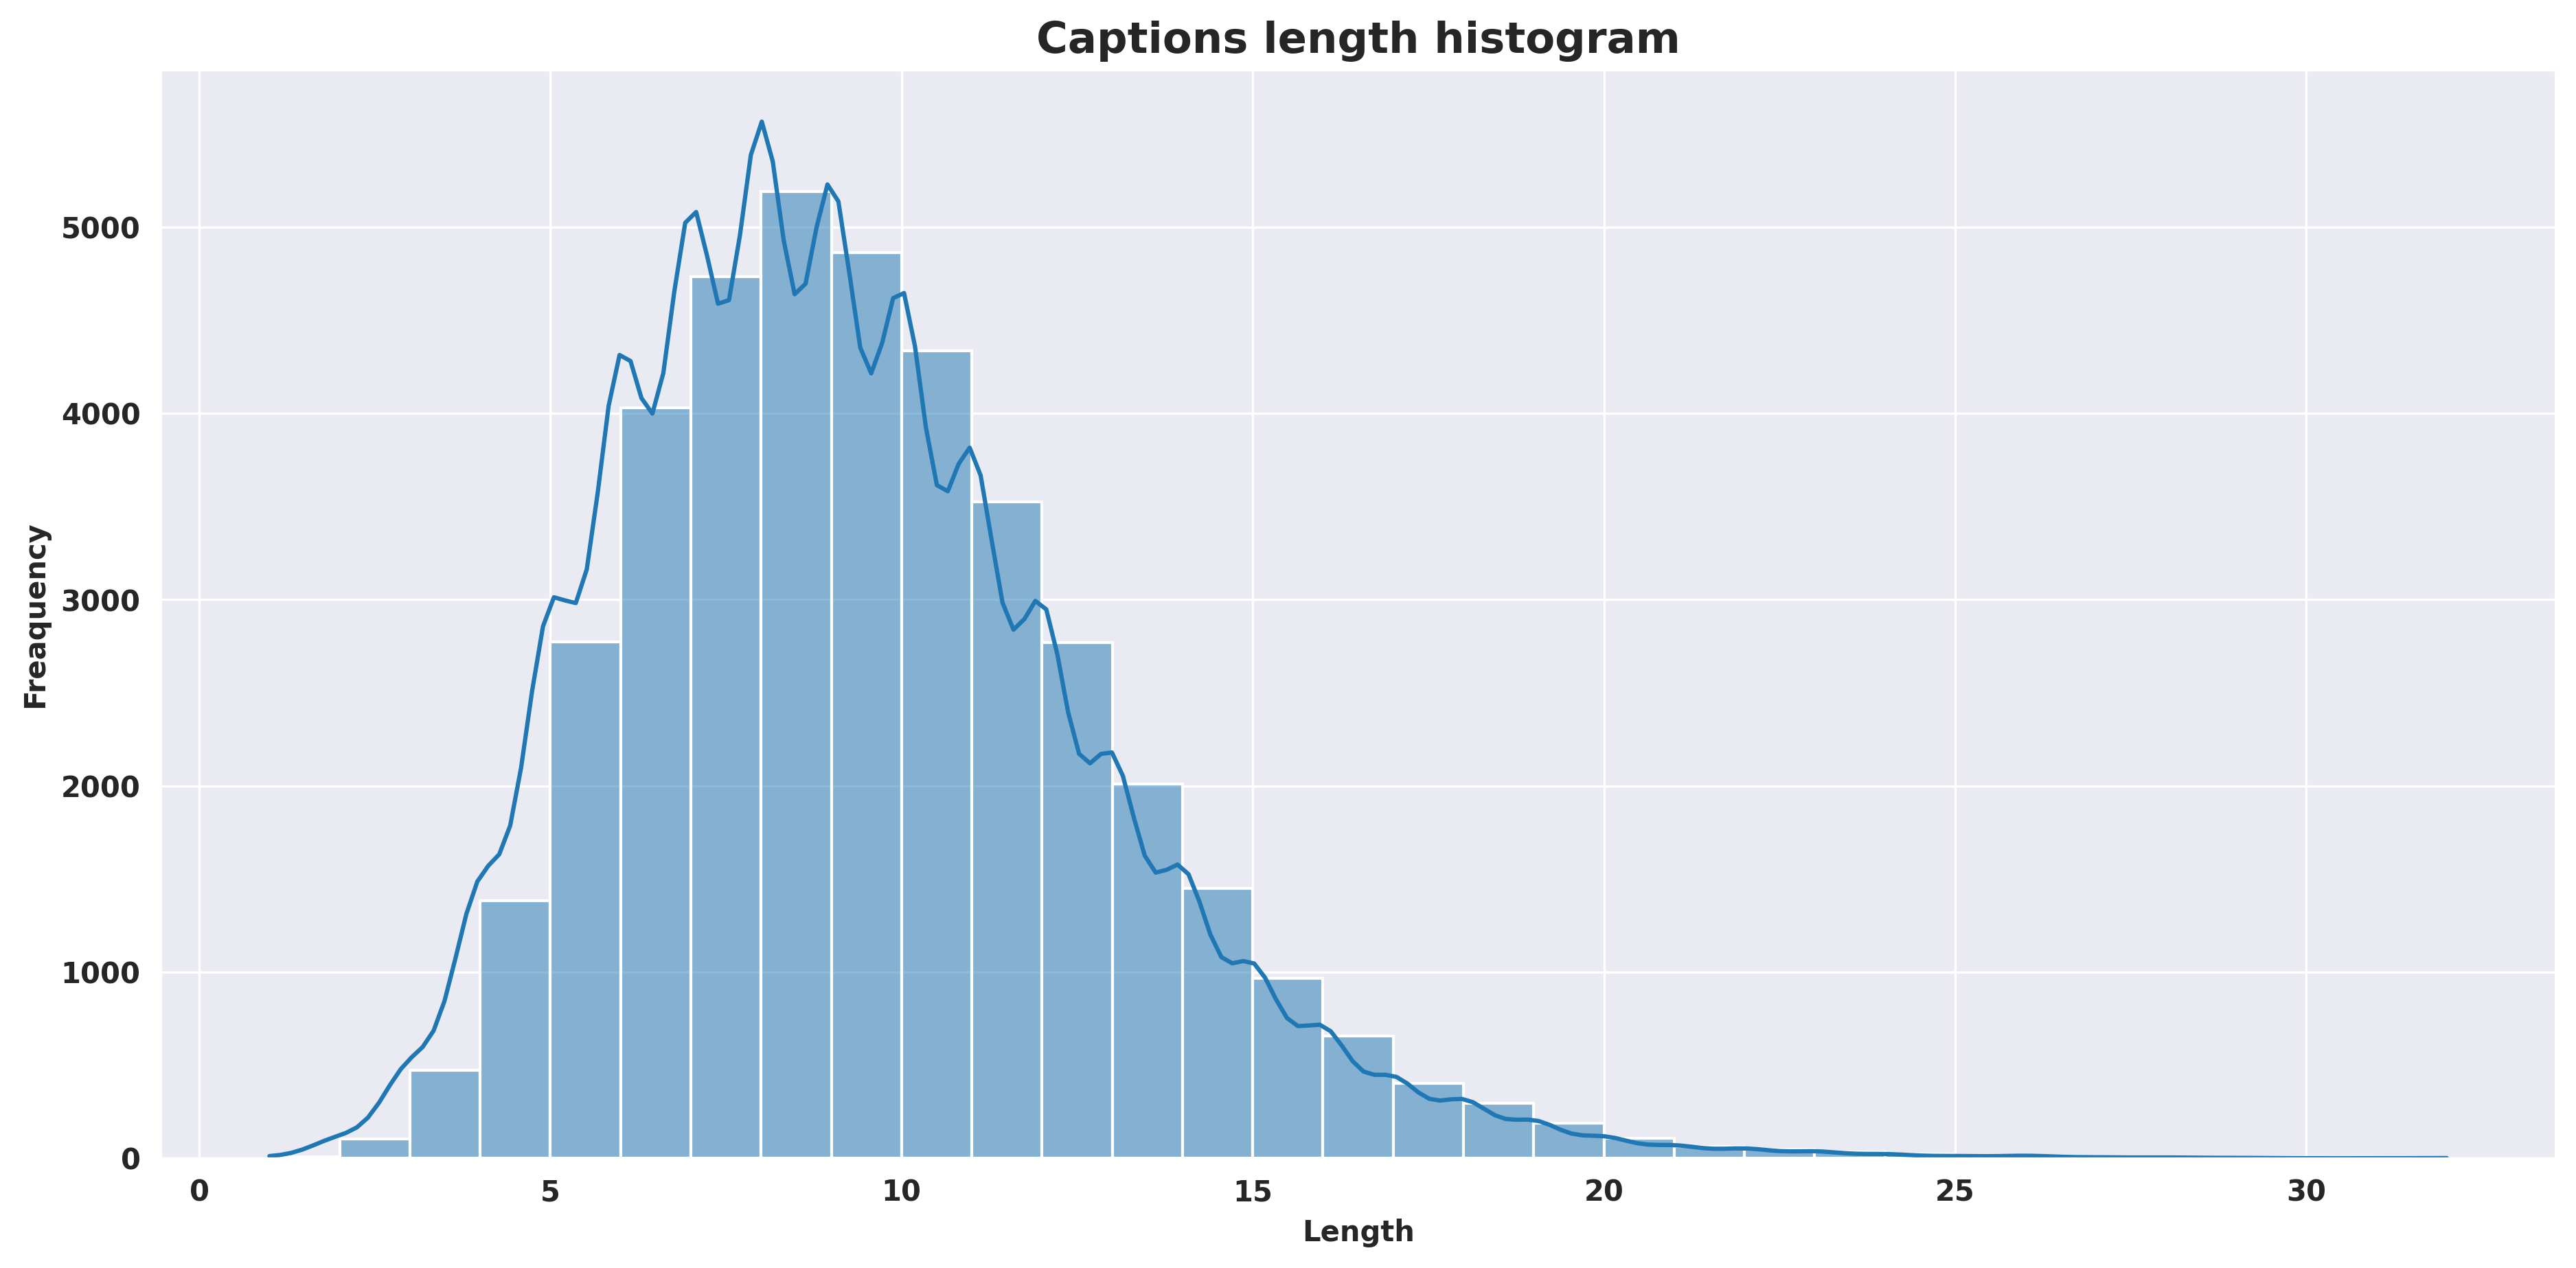

In [14]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(annotations)

#### Add the start & end token to all those captions as well

In [15]:
annotations = ['<start> ' + line + ' <end>' for line in annotations]

#### Create the vocabulary & the counter for the captions

In [16]:
vocabulary= [word.lower() for line in annotations for word in line.split()]

val_count=Counter(vocabulary)
print('Total number of words in vocabulary: ',len(val_count))

Total number of words in vocabulary:  8765


#### Visualise the top 30 occuring words in the captions

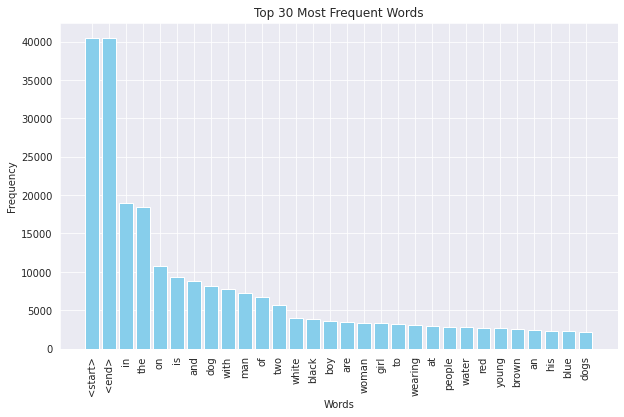

In [17]:
def plot_word_frequency(val_count, top_n=10):
    # Get the top 30 most common words
    top_words = val_count.most_common(top_n)

    # Separate the words and their frequencies
    words, counts = zip(*top_words)

    # Plot the graph
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.title("Top "+str(top_n)+ " Most Frequent Words")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

plot_word_frequency(val_count, 30)

# 1.3. Dataset creation

## 1.3.1. Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

#### Create Tokenized vectors
The tokenized vectors are created by tokenizing the captions. For example - split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. 
We will keep the total vocaublary to top 5,000 words for saving memory.

#### Replace all other words with the unknown token "UNK" .

In [18]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt + 1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = '<unk>')
# Fit the tokenizer on the text data (this builds the vocabulary)
tokenizer.fit_on_texts(annotations)

#### Create word-to-index and index-to-word mappings.

In [19]:
# Word ot index
word_index = tokenizer.word_index
print("Word to Index Index: \n")
list(word_index.items())[:20]
print('\n ---------------------------------------------------------------------------------- \n')
index_word = tokenizer.index_word
print("Index to Word: \n")
list(index_word.items())[:20]

Word to Index Index: 


 ---------------------------------------------------------------------------------- 

Index to Word: 



[(1, '<unk>'),
 (2, '<start>'),
 (3, '<end>'),
 (4, 'in'),
 (5, 'the'),
 (6, 'on'),
 (7, 'is'),
 (8, 'and'),
 (9, 'dog'),
 (10, 'with'),
 (11, 'man'),
 (12, 'of'),
 (13, 'two'),
 (14, 'white'),
 (15, 'black'),
 (16, 'boy'),
 (17, 'are'),
 (18, 'woman'),
 (19, 'girl'),
 (20, 'to')]

#### Top 30 occuring words after text processing

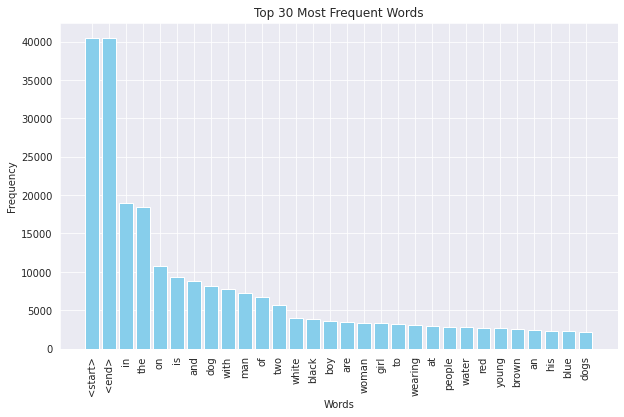

In [20]:
# Get the word counts (total occurrences of each word in the data)
word_counts = tokenizer.word_counts

# Sort the word counts by frequency
word_count_pairs = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 30 most frequent words
top_30_words = word_count_pairs[:30]

# Separate the words and their counts for plotting
words, counts = zip(*top_30_words)

# Plot the top 30 words and their frequencies
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.title('Top 30 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

#### Pad each vector to the max_length of the captions

In [21]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(annotations)
#store elements from list with maximum value
max_length = max([len(seq) for seq in sequences])

cap_vector= pad_sequences(sequences, padding='post', maxlen = max_length,
                                                          dtype='int32', value=0)

print('Max length: ' + str(max_length))
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max length: 34
The shape of Caption vector is :(40455, 34)


In [22]:
print('Captions after preprocessing:')
annotations[0:5]

Captions after preprocessing:


['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

#### Adding padding index to tokenizer
If you are using pre-trained models or certain loss functions (like SparseCategoricalCrossentropy with from_logits=True), they often expect the padding index to be 0. In such cases, explicitly assigning 0 to the <pad> token ensures compatibility with these models.

In [23]:
word_index['<pad>'] = 0
index_word[0] = '<pad>'

## 1.3.2. Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

#### Create the dataset consisting of image paths

In [24]:
unique_img_path= sorted(set(all_img_vector))

In [25]:
dataset = tf.data.Dataset.from_tensor_slices(unique_img_path)

2024-09-25 04:20:06.366753: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-25 04:20:06.366818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


#### Method to resize (299x299)  and normalise (1, -1) the image

In [26]:
def load_image(image_path):
    # Read the image from file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to a fixed size (e.g., 299X299)
    image = tf.image.resize(image, [299, 299])
    # Normalize the image
    image = image / 255.0        
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

#### Applying the function to the image path dataset

In [27]:
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

## 1.4. Feature extraction

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



#### Extract the features of the images using the last layer of pre-trained model. 
Only last layer is considered to same memory(RAM) from getting exhausted

In [28]:
# Batch the dataset
batch_size = 64
dataset = dataset.batch(batch_size, drop_remainder=False)
#Note : As we don't want to drop the last batch if it contains less than 64 elements, we set drop_remainder to false

# Prefetch the dataset for performance
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

# Get the input layer of the pre-trained model
new_input = image_model.input

# Get the output from the feature extraction layer (the last layer of the model)
hidden_layer = image_model.layers[-1].output

# Build the final model for feature extraction
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

# Print the summary of the feature extraction model
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

#### Extract features of the image using Attention model created earlier 
Once the features are created, it should be reshaped to (batch_size, 8*8, 2048)

In [30]:
# Initialize an empty dictionary to store features
image_features_dict = {}

# Function to extract features
def extract_image_features(image_batch):
    # Pass the images through the feature extraction model
    features = image_features_extract_model(image_batch)
    # Reshape features to the required shape (batch_size, 8*8, 2048)
    reshaped_features = tf.reshape(features, (features.shape[0], -1, 2048))
    return reshaped_features

# Apply the feature extraction to the dataset
for image_batch, path_batch in tqdm(dataset):
    # Extract features and reshape
    extracted_features= extract_image_features(image_batch)
    # Store the features in the dictionary with the path as the key
    for batch_feat, path in zip(extracted_features, path_batch) :
        feature_path = path.numpy().decode('utf-8')
        image_features_dict[feature_path] = batch_feat.numpy()


100%|██████████| 127/127 [00:31<00:00,  4.03it/s]


## 1.4. Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


#### Create Train and Test dataset
Train-Test split using 80-20 ratio & random state = 42
The test and train is divided based on number of images, so that the all captions related image is in only one set (train or test)

In [31]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [32]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print('--------------------------------------------------------')
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
--------------------------------------------------------
Training data for Captions: 32364
Testing data for Captions: 8091


#### Map Captions with features

Using image path, image features are extracted and then mapped it to respective caption

In [33]:
def map_func(image_path, caption):
    # Extract the image feature from the dictionary
    img_tensor = image_features_dict[image_path.decode('utf-8')]
    
    # Return the image feature and the corresponding caption
    return img_tensor, caption 

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [34]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

#### Function to generate dataset using image path and caption

This function transforms the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

In [35]:
def gen_dataset(image_paths, captions):
    
    # Step 1: Create a TensorFlow dataset from image paths and captions
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, captions))
    
    # Step 2: Apply the map_func to transform (image_path, caption) into (features, caption)
    dataset = dataset.map(lambda img_path, cap: tf.numpy_function(map_func,[img_path, cap],[tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Step 3: Shuffle the dataset
    dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True)
    
    # Step 4: Batch the dataset
    dataset = dataset.batch(BATCH_SIZE, drop_remainder = False)
    
    # Step 5: Prefetch for performance optimization
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


#### Create train test dataset

In [36]:
train_dataset=gen_dataset(path_train, cap_train)
test_dataset=gen_dataset(path_test, cap_test)

#### Shape of generated sample image and caption

In [37]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print('Sample Image shape: ',sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print('Sample Caption shape',sample_cap_batch.shape) #(batch_size,max_len)

Sample Image shape:  (64, 64, 2048)
Sample Caption shape (64, 34)


# 2. Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

#### Set the parameters

In [38]:
embedding_dim = 256 
units = 512
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

## 2.1. Encoder

In [39]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        # Build a Dense layer with ReLU activation
        self.dense = Dense(embed_dim, activation='relu')  # Adding ReLU activation
        self.batch_norm = BatchNormalization()
        self.dropout = Dropout(0.25)
    
    def call(self, inputs, training=False):
        x = self.dense(inputs)                     # Dense layer will already include ReLU activation
        x = self.batch_norm(x, training=training)
        x = self.dropout(x, training=training)
        return x

In [40]:
encoder=Encoder(embedding_dim)

## 2.2. Attention model

In [41]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units)  # Transform the hidden state
        self.W2 = Dense(units)  # Transform the features
        self.V = Dense(1)  # Final dense layer to get attention scores
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden state dimension to match features
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)  # Shape: (batch_size, 1, hidden_size)
        # Compute score using the attention mechanism
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))  # Shape: (batch_size, 8*8, 1)
        
        # Calculate attention weights
        attention_weights =  tf.nn.softmax(score, axis=1)  # Shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features  # Shape: (batch_size, 8*8, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # Reduce the time axis, Shape: (batch_size, embedding_dim)
        

        return context_vector, attention_weights

## 2.3. Decoder

In [42]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units)
        self.embed = Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform', recurrent_dropout=0.2)
        self.d1 = Dense(self.units, activation='relu')  # Optional activation, depending on your needs
        self.d2 = Dense(vocab_size)  # Output layer to predict vocab_size words
        self.dropout = tf.keras.layers.Dropout(0.25) 
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = self.dropout(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [43]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [44]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


# 3. Model training

## 3.1. Optimizer & Loss setting

1.Optimizer & Loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [45]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)


In [46]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 3.2. Checkpoint creation

In [47]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [48]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## 3.3. Train and Test step

#### Train function

While creating the train step for the model, actual target value from previous step should be passed, as the next input to the decoder.

In [49]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        # Extract the features from the image tensor
        features = encoder(img_tensor, training = True)  # shape: (batch_size, 8*8, embed_dim)
        
        # Loop over each word in the target sequence
        for i in range(1, target.shape[1]):
            # Pass the current input and image features into the decoder
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            
            # Compute loss for this timestep
            loss += loss_function(target[:, i], predictions)
            
            # Use teacher forcing: the next input to the decoder is the real target (not the prediction)
            dec_input = tf.expand_dims(target[:, i], 1)
    
    # Calculate the gradients
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    
    # Apply gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    # Compute the average loss over the entire batch
    avg_loss = loss / int(target.shape[1])
        
    return loss, avg_loss

#### Test function

While creating the test step for the model, previous prediciton should be passed, as the next input to the decoder.
This is known as teacher forcing technique

In [50]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    # Feature extraction
    features=encoder(img_tensor)
    
    # Loop over each word in the target sequence
    for i in range(1, target.shape[1]):
        # Pass the current input and image features into the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        # Compute loss for this timestep
        loss += loss_function(target[:, i], predictions)
        
        # Greedily pick the predicted word for the next input
        predicted_id = tf.argmax(predictions, axis=1)
        
        # Use the previous prediction as the next input
        dec_input = tf.expand_dims(predicted_id, 1)
    
    # Compute the average loss over the entire batch
    avg_loss = loss / int(target.shape[1])
        
    return loss, avg_loss

In [51]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    # Feature extraction
    features=encoder(img_tensor)
    
    # Loop over each word in the target sequence
    for i in range(1, target.shape[1]):
        # Pass the current input and image features into the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        # Compute loss for this timestep
        loss += loss_function(target[:, i], predictions)
        
        # Greedily pick the predicted word for the next input
        predicted_id = tf.argmax(predictions, axis=1)
        
        # Use the previous prediction as the next input
        dec_input = tf.expand_dims(predicted_id, 1)
    
    # Compute the average loss over the entire batch
    avg_loss = loss / int(target.shape[1])
        
    return loss, avg_loss

#### Test loss calulator

In [52]:
def test_loss_cal(test_dataset):
    total_loss = 0

    # Get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss = total_loss + t_loss
        avg_test_loss = total_loss/ int(target.shape[1])

    return avg_test_loss

#### Model training

In [72]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.652, & test loss is 13.051
Time taken for 1 epoch 95.9026186466217 sec

Test loss has been reduced from 100.000 to 13.051


 13%|█▎        | 2/15 [03:09<20:27, 94.41s/it]

For epoch: 2, the train loss is 0.639, & test loss is 13.508
Time taken for 1 epoch 93.14730453491211 sec



 20%|██        | 3/15 [04:43<18:52, 94.34s/it]

For epoch: 3, the train loss is 0.624, & test loss is 13.528
Time taken for 1 epoch 94.2667191028595 sec



 27%|██▋       | 4/15 [06:12<16:55, 92.29s/it]

For epoch: 4, the train loss is 0.611, & test loss is 13.796
Time taken for 1 epoch 89.1269223690033 sec



 33%|███▎      | 5/15 [07:49<15:40, 94.03s/it]

For epoch: 5, the train loss is 0.598, & test loss is 13.921
Time taken for 1 epoch 97.12943911552429 sec



 40%|████      | 6/15 [09:23<14:03, 93.78s/it]

For epoch: 6, the train loss is 0.586, & test loss is 14.314
Time taken for 1 epoch 93.27502632141113 sec



 47%|████▋     | 7/15 [10:56<12:28, 93.62s/it]

For epoch: 7, the train loss is 0.574, & test loss is 14.336
Time taken for 1 epoch 93.30268979072571 sec



 53%|█████▎    | 8/15 [12:26<10:46, 92.41s/it]

For epoch: 8, the train loss is 0.561, & test loss is 14.787
Time taken for 1 epoch 89.80666971206665 sec



 60%|██████    | 9/15 [14:04<09:24, 94.14s/it]

For epoch: 9, the train loss is 0.551, & test loss is 15.057
Time taken for 1 epoch 97.95277142524719 sec



 67%|██████▋   | 10/15 [15:42<07:56, 95.29s/it]

For epoch: 10, the train loss is 0.539, & test loss is 15.127
Time taken for 1 epoch 97.8624918460846 sec



 73%|███████▎  | 11/15 [17:20<06:24, 96.09s/it]

For epoch: 11, the train loss is 0.530, & test loss is 15.724
Time taken for 1 epoch 97.90400338172913 sec



 80%|████████  | 12/15 [18:54<04:46, 95.62s/it]

For epoch: 12, the train loss is 0.519, & test loss is 15.817
Time taken for 1 epoch 94.53634572029114 sec



 87%|████████▋ | 13/15 [20:29<03:11, 95.51s/it]

For epoch: 13, the train loss is 0.509, & test loss is 16.470
Time taken for 1 epoch 95.24747514724731 sec



 93%|█████████▎| 14/15 [22:07<01:36, 96.28s/it]

For epoch: 14, the train loss is 0.500, & test loss is 16.276
Time taken for 1 epoch 98.05362725257874 sec



100%|██████████| 15/15 [23:46<00:00, 95.12s/it]

For epoch: 15, the train loss is 0.491, & test loss is 16.620
Time taken for 1 epoch 98.91452312469482 sec



#### Training graph plot

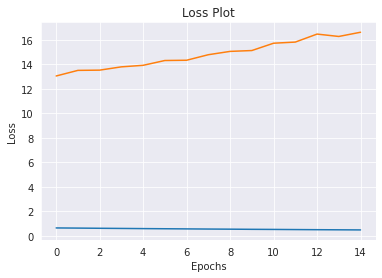

In [73]:
plt.plot(loss_plot, label='Training Loss')
plt.plot(test_loss_plot, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), hence the train loss is decreasing while the test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, to achieve better results we can run it more epochs.

# 4. Model Evaluation
1.Evaluation function using greedy search

2.Evaluation function using beam search ( optional)

3.Test on a sample data using BLEU score

## 4.1. Greedy Search

In [74]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder
        # print(f"Predictions: {tf.argmax(predictions, axis=-1).numpy()}")
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        
        # map the id to the word from tokenizer and append the value to the result list
        result.append(index_word[predicted_id])

        if index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [75]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize = 14, color = 'red')
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [76]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [77]:
img_test = path_test.copy()

#### BLEU Score using Greedy model evaluation

In [78]:
attention_features_shape = 64 
def predict_caption(test_image, real_caption):
    
    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]    
    
    return pred_caption, result, attention_plot

In [79]:
weights_array = [
    (1.0, 0.0, 0.0, 0.0),    # Unigrams only
    (0.5, 0.5, 0.0, 0.0),    # Equal emphasis on unigrams and bigrams
    (0.33, 0.33, 0.33, 0.0), # Balanced up to trigrams
    (0.25, 0.25, 0.25, 0.25),# Equal weighting across unigrams, bigrams, trigrams, and four-grams
   
]


In [80]:
df_test = pd.DataFrame(list(zip(path_test, cap_test)),columns =['Path', 'Captions']) 

In [81]:
def fetch_predicted_caption(test_image_path, real_cap_vector):  
    
    
    # Create an empty DataFrame with columns
    result_df = pd.DataFrame(columns=['Image', 'Result Percentage', 'Weight', 'Real Caption', 'Predicted Caption'])
    
    # Display image path
    print(test_image_path)
    
    #Display image
    img = mpimg.imread(test_image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()
     
    # Display real caption
    real_caption1 = ' '.join([index_word[i] for i in real_cap_vector if i not in [0]])
    real_caption1 = filt_text(real_caption1)
    
    # Predict captn
    pred_caption1, result, attention_plot = predict_caption(test_image_path, real_caption1)
    
    temp_img = np.array(Image.open(test_image_path))
    plot_attmap(result, attention_plot, test_image_path)
    Image.open(test_image_path)

    for index,weight in enumerate(weights_array):         
        
        real_appn = []
        real_appn.append(real_caption1.split())
        reference = real_appn
        candidate = pred_caption1.split()
        # Apply smoothing
        smoothing_fn = SmoothingFunction().method4  # You can use different smoothing methods
        score = sentence_bleu(reference, candidate, weights=weight, smoothing_function=smoothing_fn)
        precentage1 = f'{score*100:.2f}'
        # Data to be added as a new row
        tmp_data = {
            'Image': test_image_path, 
            'Result Percentage': precentage1,
            'Weight':weight,
            'Real Caption':real_caption1,
            'Predicted Caption':pred_caption1            
            }

        # Append the new row to the DataFrame
        result_df = result_df.append(tmp_data, ignore_index=True)
        
    # Create Markdown content with HTML
    markdown_content = "<hr>"

    display(Markdown(markdown_content))
    return result_df[['Result Percentage','Weight','Real Caption','Predicted Caption']]

### Greedy search evaluation results

-------------------- TEST - 1 ----------------
datasets/flickr/Images/241347300_7c84ecf764.jpg


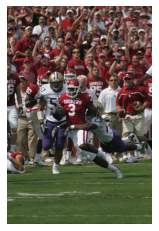

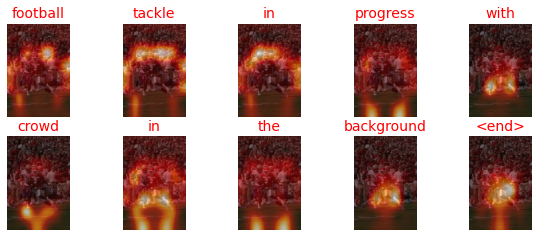

<hr>

,Result Percentage,Weight,Real Caption,Predicted Caption
0,29.83,"(1.0, 0.0, 0.0, 0.0)",football player in red being tackled by opponents in white,football tackle in progress with crowd in the background
1,8.56,"(0.5, 0.5, 0.0, 0.0)",football player in red being tackled by opponents in white,football tackle in progress with crowd in the background
2,4.83,"(0.33, 0.33, 0.33, 0.0)",football player in red being tackled by opponents in white,football tackle in progress with crowd in the background
3,3.03,"(0.25, 0.25, 0.25, 0.25)",football player in red being tackled by opponents in white,football tackle in progress with crowd in the background


-------------------- TEST - 2 ----------------
datasets/flickr/Images/3186073578_6e115f45f5.jpg


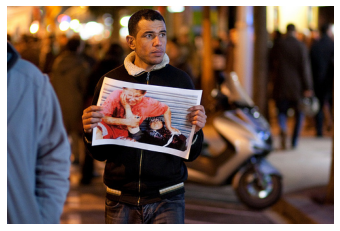

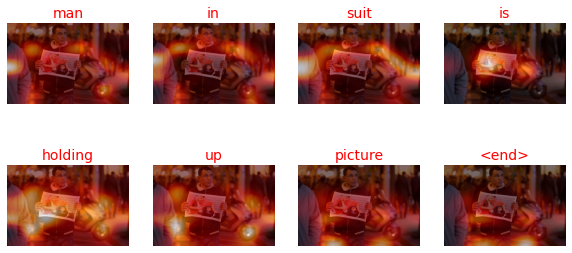

<hr>

,Result Percentage,Weight,Real Caption,Predicted Caption
0,64.41,"(1.0, 0.0, 0.0, 0.0)",man is standing in front of holding up picture,man in suit is holding up picture
1,40.17,"(0.5, 0.5, 0.0, 0.0)",man is standing in front of holding up picture,man in suit is holding up picture
2,29.22,"(0.33, 0.33, 0.33, 0.0)",man is standing in front of holding up picture,man in suit is holding up picture
3,17.26,"(0.25, 0.25, 0.25, 0.25)",man is standing in front of holding up picture,man in suit is holding up picture


-------------------- TEST - 3 ----------------
datasets/flickr/Images/216172386_9ac5356dae.jpg


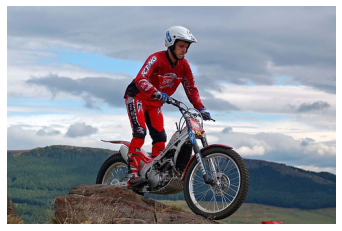

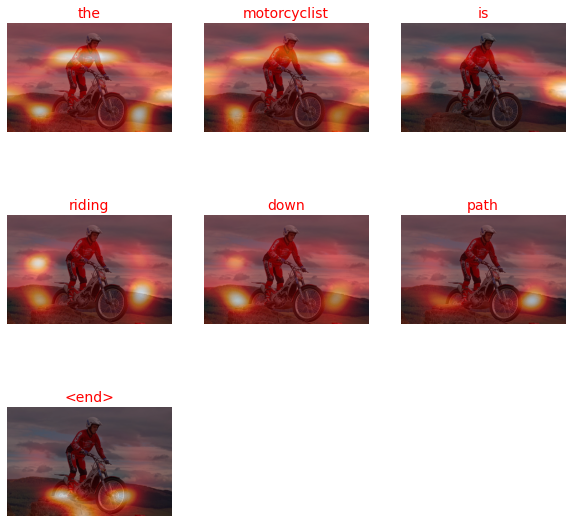

<hr>

,Result Percentage,Weight,Real Caption,Predicted Caption
0,14.11,"(1.0, 0.0, 0.0, 0.0)",motocross bike is being ridden over rocks,the motorcyclist is riding down path
1,6.54,"(0.5, 0.5, 0.0, 0.0)",motocross bike is being ridden over rocks,the motorcyclist is riding down path
2,4.46,"(0.33, 0.33, 0.33, 0.0)",motocross bike is being ridden over rocks,the motorcyclist is riding down path
3,3.18,"(0.25, 0.25, 0.25, 0.25)",motocross bike is being ridden over rocks,the motorcyclist is riding down path


In [86]:
from IPython.display import Audio, display, Markdown
for i in range(3):
    print('-------------------- TEST - {} ----------------'.format(i+1))
    rid = np.random.randint(0, len(path_test))
    test_image_path = path_test.iloc[rid]
    real_cap_vector = cap_test[rid]
    df_result = fetch_predicted_caption(test_image_path, real_cap_vector)
    display(df_result)
    
    speech = gTTS('Predicted Caption : ' + str(df_result['Predicted Caption'].head(1).values), lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display(Audio(audio_file, rate = None, autoplay = False))



## 5. Conclusion

1. As observed from table generated above, getting good Bleu score for below weights - <br>
    [1.0, 0.0, 0.0, 0.0] <br>
    [0.5, 0.5, 0.0, 0.0] <br>
    
2. Due to small dataset (8091 pictures only), the prediction is not very accurate. 

3. the BLEU Score pencentage achived varies between <b>30% to 65%</b>. This is due limited data causing class imbalance. 

4. We used cross entropy - <b>SparseCategoricalCrossentropy</b> to calculate the loss.

5. <b>Batch normalization</b> and <b>Drop out</b> (0.25) have been added in the encoder and decoder model <b>to avoid overfitting</b>.

6. We also made use of <b>Teacher forcing </b> to decide the next input to the decoder. It ensured faster convergence and a reliably stable model.

7. <b>Vocabulary</b> of top <b>5000</b> words have been considered, due to limitation in storage and processing power.

8. We made use of <b>Greedy Search</b> to calculate the probability of words as per their occurrence in the given vocabulary list. It outputs the word with the highest probability.
